### Import Libaray

In [1]:
import MetaTrader5 as mt
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

import warnings 
warnings.filterwarnings("ignore")


c:\Users\User\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
c:\Users\User\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


### MT5 Initialize

In [2]:
# establish MetaTrader 5 connection to a specified trading account
if not mt.initialize(login=116662489,server="Exness-MT5Trial6",password="muxko9-boptEj"):
    print("initialize() failed, error code =",mt.last_error())
    quit()

# display data on connection status, server name and trading account
print(mt.terminal_info())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4380, maxbars=100000, codepage=874, ping_last=33217, community_balance=0.0, retransmission=0.39346983159491206, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='Thai', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


### Import data from MT5

In [3]:
symbol = "XAUUSDm" #gold
timeframe = mt.TIMEFRAME_M5 #5 minutes
utc_from = pd.Timestamp('2024-05-09') #start date
utc_to = pd.Timestamp.now() 

### Import to DataFrame

In [4]:
# Retrieve the data
rates = mt.copy_rates_range(symbol, timeframe, utc_from, utc_to)
df = pd.DataFrame(rates)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,1715212800,2308.733,2309.190,2308.125,2309.022,438,200,0
1,1715213100,2309.073,2309.170,2308.115,2308.257,351,200,0
2,1715213400,2308.219,2308.304,2307.851,2307.947,261,199,0
3,1715213700,2308.002,2308.386,2307.762,2308.179,241,200,0
4,1715214000,2308.209,2308.209,2307.815,2307.930,204,200,0
...,...,...,...,...,...,...,...,...
6653,1718174400,2316.485,2317.200,2316.482,2316.879,374,199,0
6654,1718174700,2316.878,2316.886,2315.909,2316.241,340,200,0
6655,1718175000,2316.253,2317.692,2316.007,2316.007,400,199,0
6656,1718175300,2316.004,2316.143,2314.535,2314.880,408,200,0


In [5]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1715212800,2308.733,2309.190,2308.125,2309.022,438,200,0
1,1715213100,2309.073,2309.170,2308.115,2308.257,351,200,0
2,1715213400,2308.219,2308.304,2307.851,2307.947,261,199,0
3,1715213700,2308.002,2308.386,2307.762,2308.179,241,200,0
4,1715214000,2308.209,2308.209,2307.815,2307.930,204,200,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         6658 non-null   int64  
 1   open         6658 non-null   float64
 2   high         6658 non-null   float64
 3   low          6658 non-null   float64
 4   close        6658 non-null   float64
 5   tick_volume  6658 non-null   uint64 
 6   spread       6658 non-null   int32  
 7   real_volume  6658 non-null   uint64 
dtypes: float64(4), int32(1), int64(1), uint64(2)
memory usage: 390.2 KB


- Rename col to match with backtesting input data type
- Remove col `'tick_volume'`  `'spread'`  `'real_volume'` due to tick_volumen data is not clean and for other is not use

In [7]:
df.rename(columns={'time':'Date','open':'Open','high':'High','low':'Low','close':'Close'},inplace=True)
df = df.drop(['tick_volume', 'spread','real_volume'],axis=1)

In [8]:
df.head() # cehck the data after renaming

,Date,Open,High,Low,Close
0,1715212800,2308.733,2309.190,2308.125,2309.022
1,1715213100,2309.073,2309.170,2308.115,2308.257
2,1715213400,2308.219,2308.304,2307.851,2307.947
3,1715213700,2308.002,2308.386,2307.762,2308.179
4,1715214000,2308.209,2308.209,2307.815,2307.930


In [9]:
df.info() # Check data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6658 non-null   int64  
 1   Open    6658 non-null   float64
 2   High    6658 non-null   float64
 3   Low     6658 non-null   float64
 4   Close   6658 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 260.2 KB


In [10]:
df.describe()

,Date,Open,High,Low,Close
count,6.658000e+03,6658.000000,6658.000000,6658.000000,6658.000000
mean,1.716701e+09,2354.739642,2355.615400,2353.834546,2354.738500
std,8.580516e+05,33.817312,33.892351,33.735373,33.811534
min,1.715213e+09,2286.935000,2288.755000,2286.726000,2286.937000
25%,1.715907e+09,2333.784000,2334.633500,2332.881750,2333.769250
50%,1.716774e+09,2347.626000,2348.435000,2346.658500,2347.639000
75%,1.717482e+09,2373.016750,2373.774750,2372.165750,2373.025250
max,1.718176e+09,2449.859000,2450.025000,2447.692000,2449.823000


In [11]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')
df = df.rename(columns={'Date': 'Date/Time'})
df.set_index('Date/Time', inplace=True)

In [12]:
# Display the first few rows of the DataFrame
df.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-09 00:00:00,2308.733,2309.190,2308.125,2309.022
2024-05-09 00:05:00,2309.073,2309.170,2308.115,2308.257
2024-05-09 00:10:00,2308.219,2308.304,2307.851,2307.947
2024-05-09 00:15:00,2308.002,2308.386,2307.762,2308.179
2024-05-09 00:20:00,2308.209,2308.209,2307.815,2307.930


In [13]:
df.tail()

,Open,High,Low,Close
Date/Time,,,,
2024-06-12 06:40:00,2316.485,2317.200,2316.482,2316.879
2024-06-12 06:45:00,2316.878,2316.886,2315.909,2316.241
2024-06-12 06:50:00,2316.253,2317.692,2316.007,2316.007
2024-06-12 06:55:00,2316.004,2316.143,2314.535,2314.880
2024-06-12 07:00:00,2314.833,2315.171,2314.616,2314.746


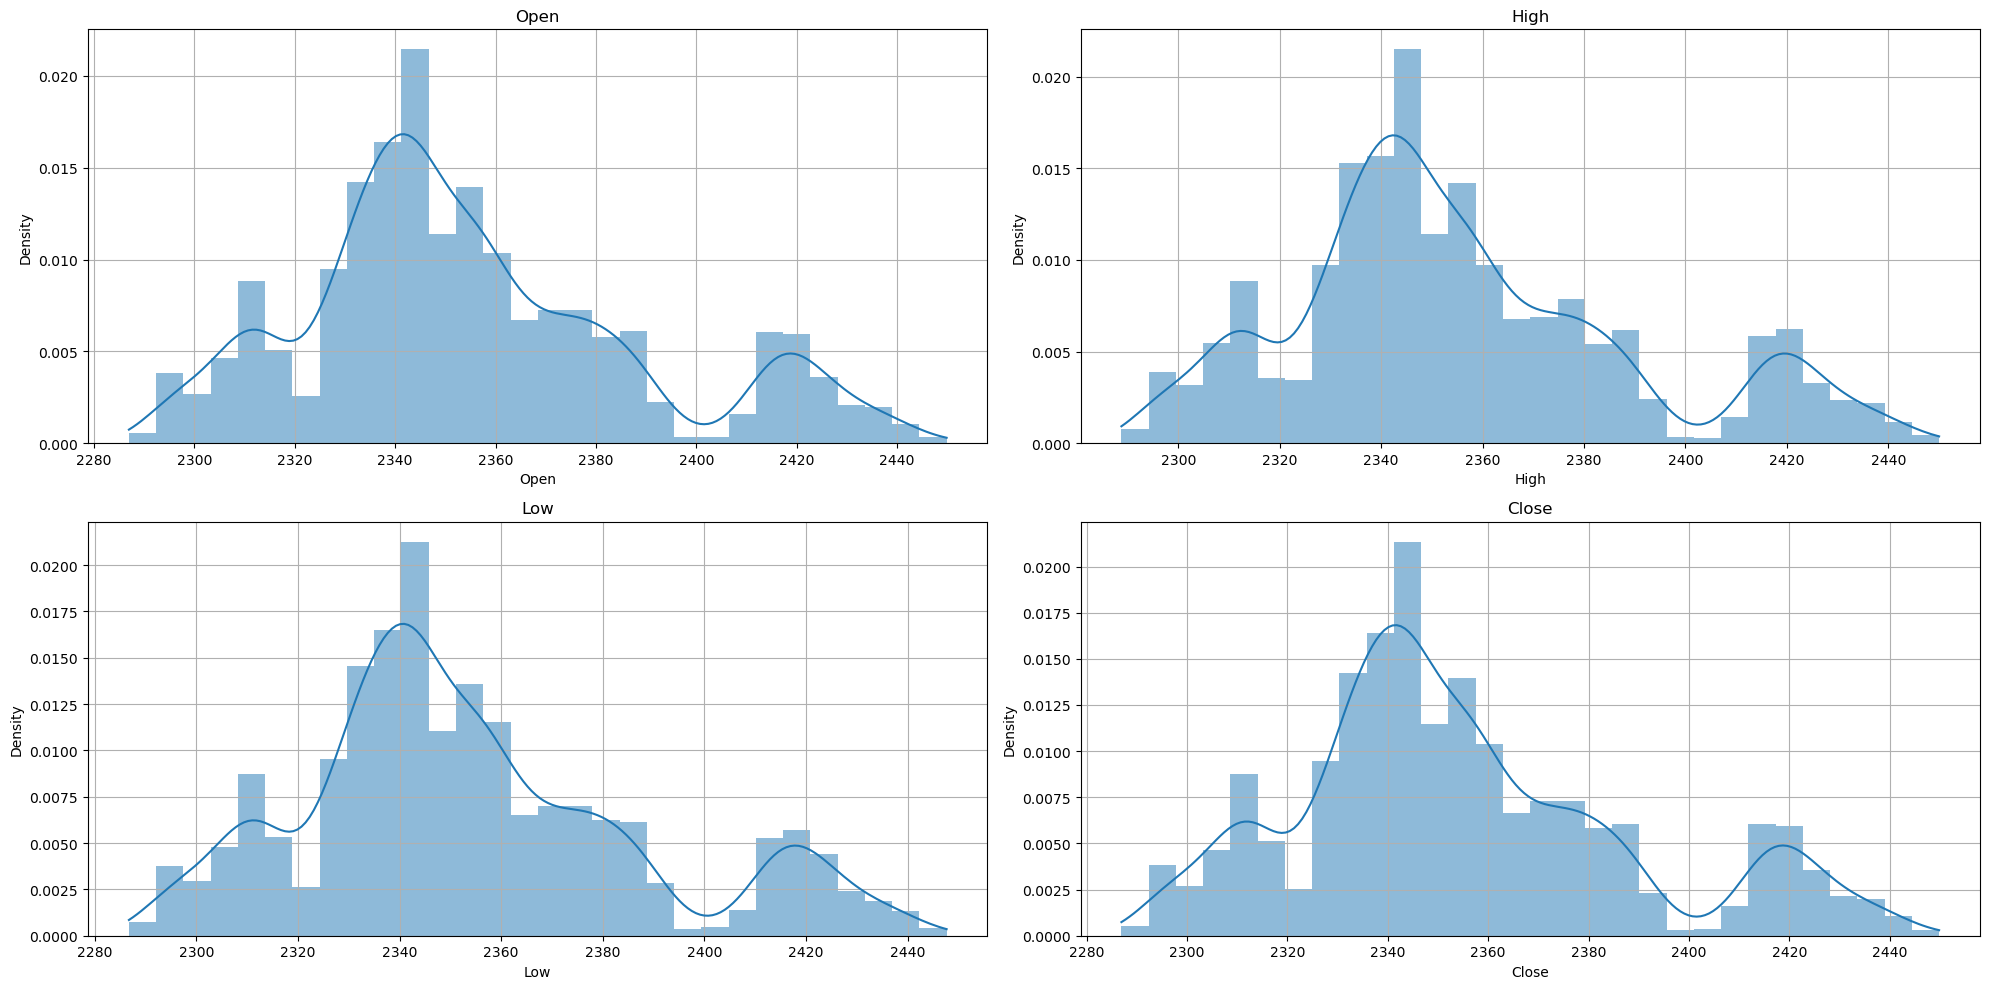

In [14]:
features = ['Open', 'High', 'Low', 'Close'] 

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for i, col in enumerate(features): 
  ax = plt.subplot(2, 2, i+1)
  sns.histplot(df[col], label="100% Equities", kde=True, stat="density", linewidth=0, ax=ax, bins=30) 
  ax.set_title(col)
  ax.set_xlabel(col)
  ax.set_ylabel('Density')
  ax.grid()

plt.tight_layout()
plt.show()

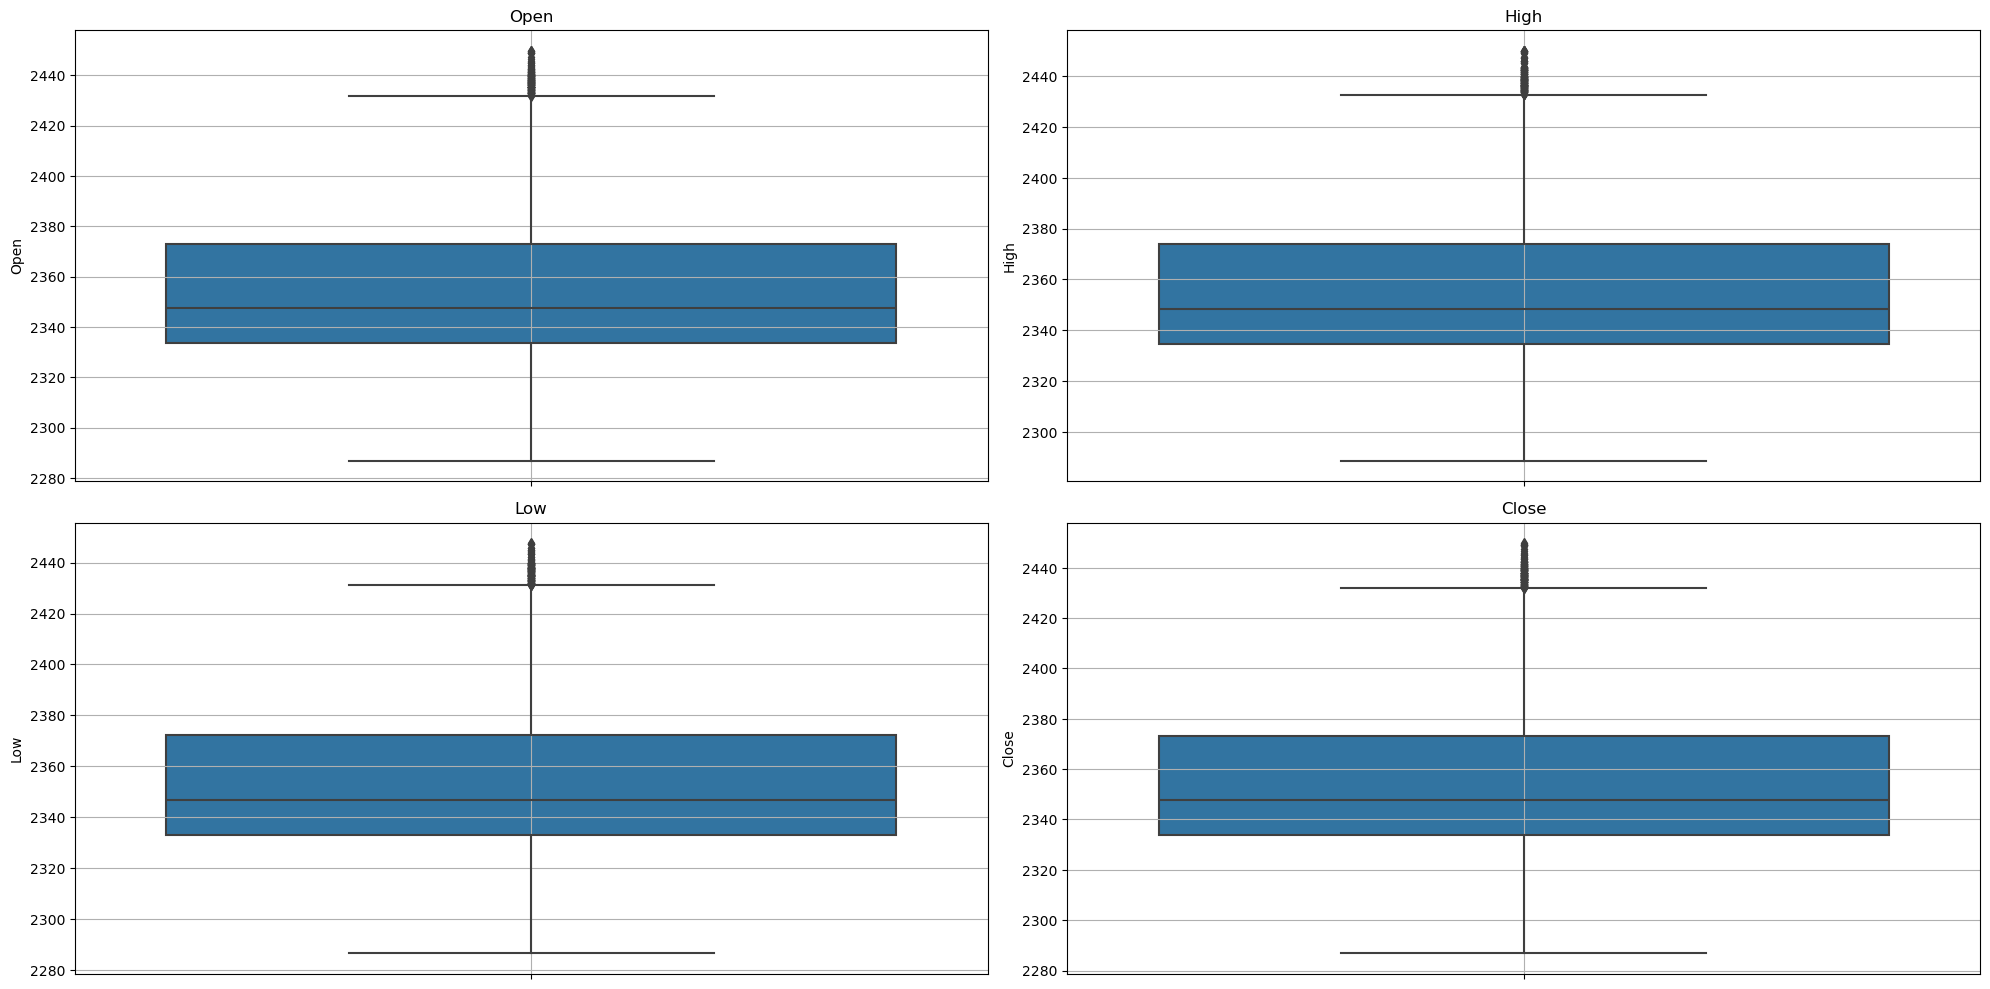

In [15]:
features = ['Open', 'High', 'Low', 'Close'] 

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for i, col in enumerate(features): 
  ax = plt.subplot(2, 2, i+1)
  sns.boxplot(y=df[col], ax=ax) 
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel(col)
  ax.grid()

plt.tight_layout()
plt.show()

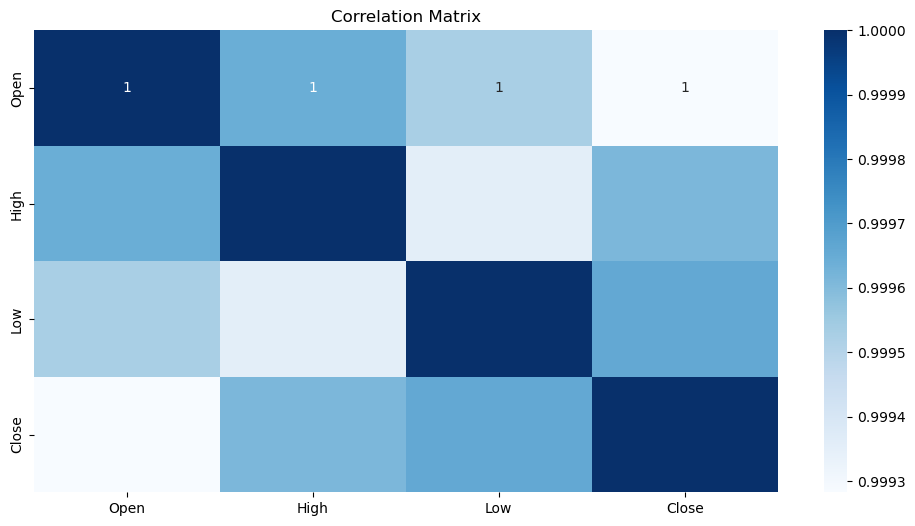

In [16]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


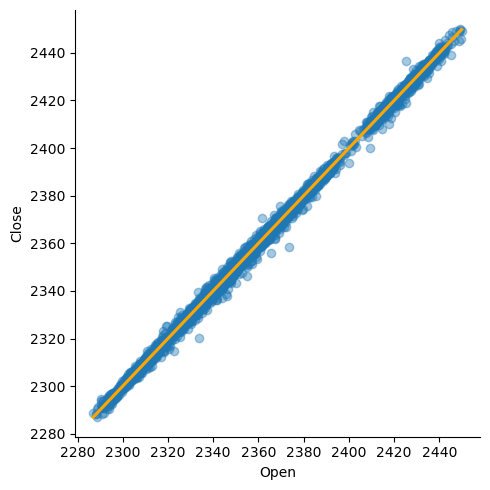

In [17]:
sns.lmplot(x='Open', y='Close', data=df, ci=None,
           scatter_kws={'alpha':0.4},
           line_kws={'color':'orange'})

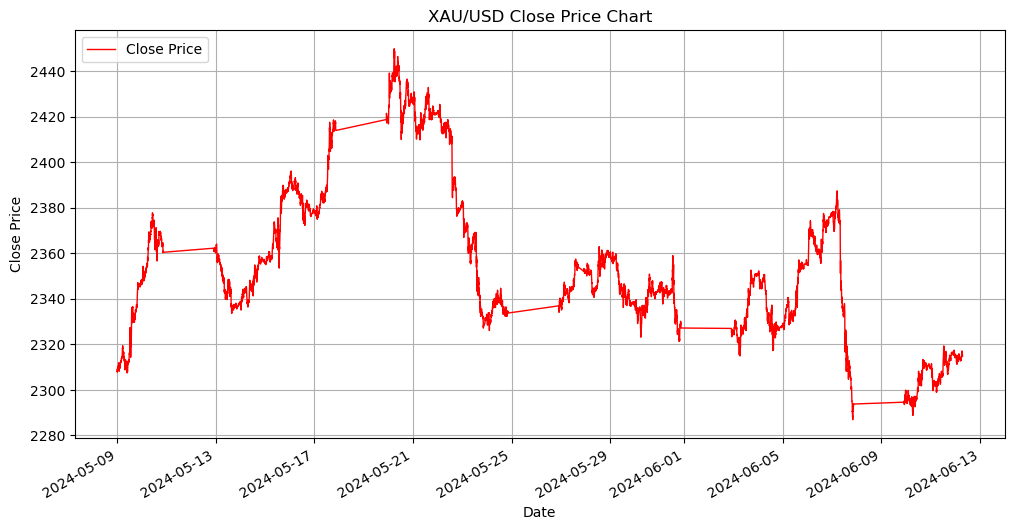

In [18]:
df_plot = df['Close'].plot(figsize=(12, 6), 
                           title='XAU/USD Close Price Chart', 
                           grid=True, 
                           color='red', 
                           label='Close Price',
                           lw=1)
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Close Price')
df_plot.legend(loc='upper left')
plt.show()

In [19]:
df.duplicated().sum()

0

In [20]:
df.isnull().sum().sum()

0

Get data from the current month for testing

In [21]:
# # get all data today for testing
# # Define the specific date
# specific_date = pd.Timestamp.today().normalize()
# print('Today(date-time):',specific_date)
# # Select the rows for the specific date
# df_specific_date = df[df.index.date == specific_date.date()]
# test_size = df_specific_date.shape[0]
# # Print the DataFrame for the specific date
# print('Test_size:',test_size)
# df_specific_date.head()


# get all data for the current month for testing
# Define the current month
current_month = pd.Timestamp.today().normalize().month
print('Current Month:', current_month)

# Select the rows for the current month
df_current_month = df[df.index.month == current_month]
test_size = df_current_month.shape[0]

# Print the DataFrame for the current month
print('Test_size:', test_size)
df_current_month.head()

Current Month: 6
Test_size: 2039


,Open,High,Low,Close
Date/Time,,,,
2024-06-02 22:05:00,2328.496,2328.760,2326.583,2327.009
2024-06-02 22:10:00,2327.043,2327.104,2324.172,2325.173
2024-06-02 22:15:00,2325.144,2326.622,2325.076,2325.931
2024-06-02 22:20:00,2325.932,2325.950,2324.535,2325.247
2024-06-02 22:25:00,2325.243,2325.243,2323.340,2323.340


### Preparing Data for Time Series Prediction with Windowed Sequences

In this section, we will prepare our data for time series prediction using windowed sequences. This involves several steps:
1. **Defining Features and Window Size**
2. **Initializing Scalers**
3. **Scaling the Data**
4. **Splitting the Data into Training and Testing Sets**
5. **Creating Sequences for Training and Testing**

In [22]:
#### 1. Defining Features and Window Size
# Define features
features = ['Open', 'High', 'Low', 'Close']
# Define window size
window_size = 25

#### 2. Scaling the Data
# Initialize the MinMaxScaler for each feature
scalers = {feature: MinMaxScaler() for feature in features}

#### 3. Splitting the Data
# Scale the data
scaled_data = {feature: scalers[feature].fit_transform(df[feature].values.reshape(-1, 1)) for feature in features}

#### 4. Splitting the Data
# Split the data into training and testing sets
train_data = {feature: scaled_data[feature][:-test_size - window_size] for feature in features}
test_data = {feature: scaled_data[feature][-test_size - window_size:] for feature in features}

#### 5. Creating Sequences
# Function to create sequences for training and testing
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train = {feature: [] for feature in features}
y_train = {feature: [] for feature in features}
X_test = {feature: [] for feature in features}
y_test = {feature: [] for feature in features}

for feature in features:
    X_train[feature], y_train[feature] = create_sequences(train_data[feature], window_size)
    X_test[feature], y_test[feature] = create_sequences(test_data[feature], window_size)

# Print the shapes of the training and testing data for each feature
for feature in features:
    print(f"{feature} - X_train shape: {X_train[feature].shape}, y_train shape: {y_train[feature].shape}")
    print(f"{feature} - X_test shape: {X_test[feature].shape}, y_test shape: {y_test[feature].shape}")
    print("-"*30)


Open - X_train shape: (4569, 25), y_train shape: (4569,)
Open - X_test shape: (2039, 25), y_test shape: (2039,)
------------------------------
High - X_train shape: (4569, 25), y_train shape: (4569,)
High - X_test shape: (2039, 25), y_test shape: (2039,)
------------------------------
Low - X_train shape: (4569, 25), y_train shape: (4569,)
Low - X_test shape: (2039, 25), y_test shape: (2039,)
------------------------------
Close - X_train shape: (4569, 25), y_train shape: (4569,)
Close - X_test shape: (2039, 25), y_test shape: (2039,)
------------------------------


### Training Linear Regression Models and Making Predictions

In this section, we will train separate linear regression models for each feature and make predictions. The results will be stored in DataFrames for actual and predicted values.

#### Steps:
1. **Initialize Empty DataFrames for Actual and Predicted Values**
2. **Loop Through Each Feature to Train the Model and Make Predictions**
3. **Concatenate the Results for Each Feature**

In [28]:
# Initialize empty DataFrames for actual and predicted values
df_actual = pd.DataFrame(index=df.index[-test_size-window_size:-window_size])
df_pred = pd.DataFrame(index=df.index[-test_size-window_size:-window_size])

# Loop through each feature
for feature in features:
    # Train the model
    model = LinearRegression()
    model.fit(X_train[feature], y_train[feature])
    
    # Make predictions
    y_pred = model.predict(X_test[feature])
    
    # Create DataFrames for actual and predicted values for the current feature
    df_actual_feature = pd.DataFrame({f'{feature}': y_test[feature]}, index=df.index[-test_size-window_size:-window_size])
    df_pred_feature = pd.DataFrame({f'{feature}': y_pred}, index=df.index[-test_size-window_size:-window_size])
    
    # Concatenate the DataFrames for the current feature with the overall DataFrames
    df_actual = pd.concat([df_actual, df_actual_feature], axis=1)
    df_pred = pd.concat([df_pred, df_pred_feature], axis=1)


In [29]:
df_actual.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-31 18:55:00,0.255094,0.248062,0.247611,0.246013
2024-05-31 19:00:00,0.246176,0.237794,0.232633,0.234741
2024-05-31 19:05:00,0.234520,0.234805,0.238249,0.239394
2024-05-31 19:10:00,0.239357,0.230638,0.234888,0.235195
2024-05-31 19:15:00,0.235128,0.226254,0.227464,0.223488


In [30]:
df_pred.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-31 18:55:00,0.250166,0.243934,0.252213,0.246773
2024-05-31 19:00:00,0.254529,0.248882,0.247191,0.247443
2024-05-31 19:05:00,0.248087,0.237153,0.231775,0.234988
2024-05-31 19:10:00,0.234847,0.233726,0.239675,0.239379
2024-05-31 19:15:00,0.239112,0.230854,0.233821,0.234958


### Calculating and Evaluating Metrics for Each Feature

In this section, we will calculate and evaluate various performance metrics for each feature's model. The metrics include Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2). The results will be stored in a DataFrame for easy visualization and analysis.

#### Steps:
1. **Initialize an Empty List for Metrics**
2. **Train and Evaluate a Separate Model for Each Feature**
3. **Convert the Metrics List to a DataFrame**

In [31]:
metrics = []
# Train and evaluate a separate model for each feature
for feature in features:
 
    # Calculate the metrics
    mae = mean_absolute_error(y_test[feature], y_pred)
    mse = mean_squared_error(y_test[feature], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[feature], y_pred)
    # Append the metrics to the list
    metrics.append([feature, mae, mse, rmse, r2, r2 * 100])

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Feature', 'MAE', 'MSE', 'RMSE', 'R2', 'R2 (%)'])
metrics_df.head()

,Feature,MAE,MSE,RMSE,R2,R2 (%)
0,Open,0.000631,0.000001,0.001013,0.999955,99.995460
1,High,0.005690,0.000045,0.006708,0.998052,99.805151
2,Low,0.004254,0.000050,0.007072,0.997841,99.784146
3,Close,0.005210,0.000062,0.007894,0.997244,99.724377


### Plotting Predicted vs. Actual Values for the Last 10 Data Points

In this section, we will create bar plots to compare the predicted and actual values for each feature for the last 10 data points. This visualization helps us understand the performance of our model on recent data points.

#### Steps:
1. **Import Necessary Libraries**
2. **Define Bar Width and Indices**
3. **Create Bar Plots for Each Feature**

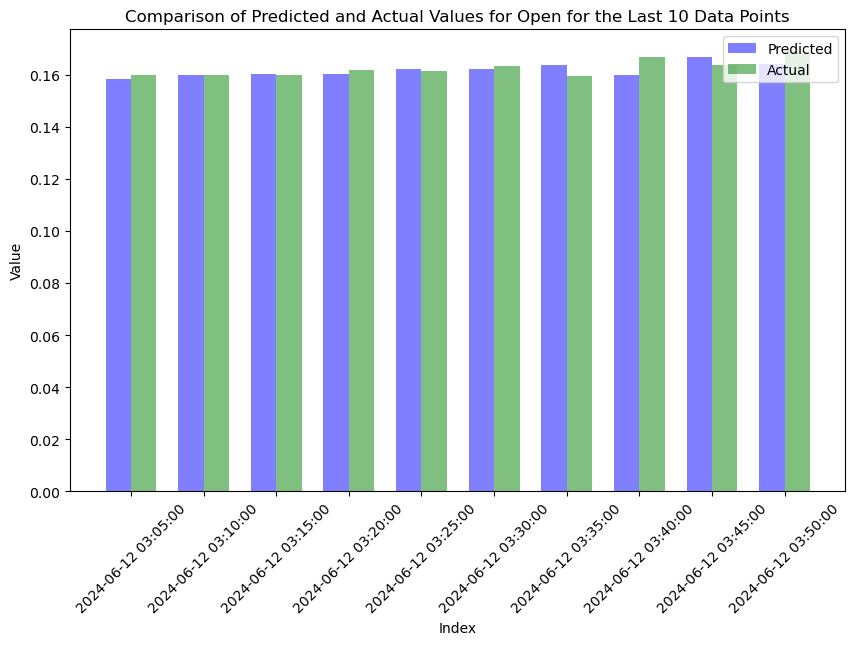

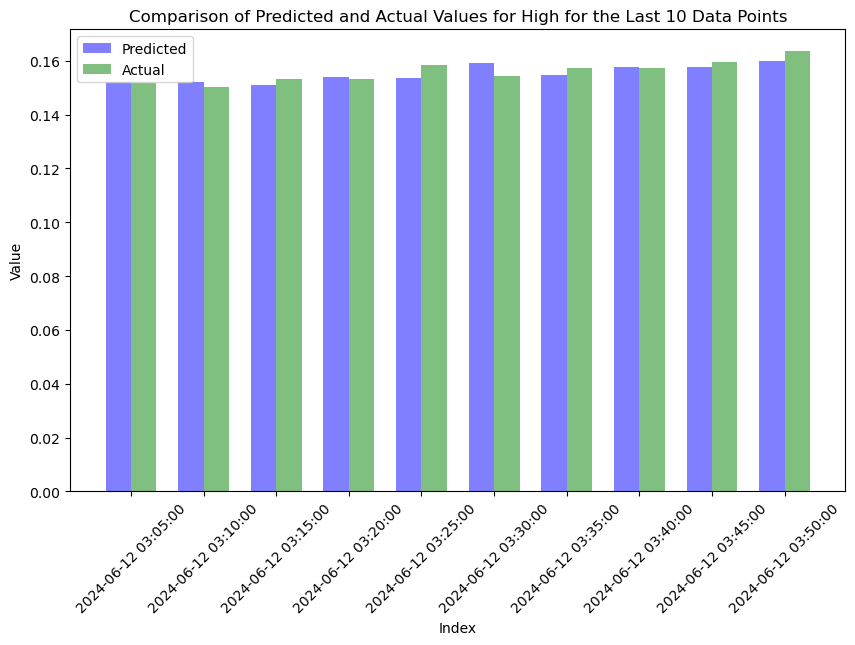

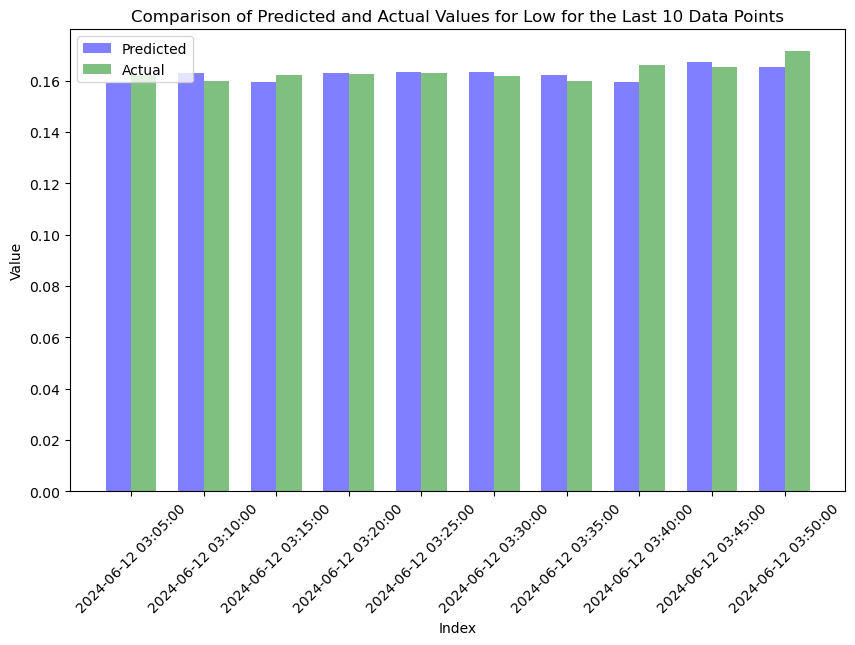

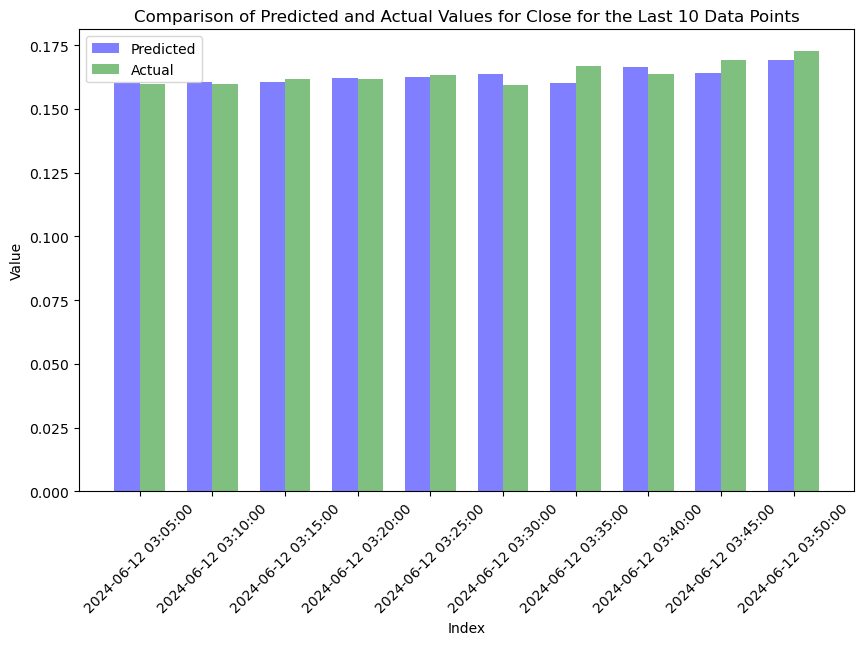

In [32]:
import numpy as np

# Get the indices
indices = df_pred.index[-10:]  # Select the last 10 indices

# Define the width of the bars
bar_width = 0.35

# Create an array of indices for positioning the bars
x = np.arange(len(indices))

# Iterate over each feature
for feature in features:
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the predicted values
    plt.bar(x - bar_width/2, df_pred[feature][-10:], color='blue', width=bar_width, alpha=0.5, label='Predicted')

    # Plot the actual values
    plt.bar(x + bar_width/2, df_actual[feature][-10:], color='green', width=bar_width, alpha=0.5, label='Actual')

    # Set the x-axis ticks and labels
    plt.xticks(x, indices, rotation=45)  # Rotate the x-labels by 45 degrees

    # Set the x-axis label
    plt.xlabel('Index')

    # Set the y-axis label
    plt.ylabel('Value')

    # Set the title
    plt.title(f'Comparison of Predicted and Actual Values for {feature} for the Last 10 Data Points')

    # Set the legend
    plt.legend()

    # Show the plot
    plt.show()


### Plotting Predicted vs. Actual Close Prices for Today

In this section, we will filter the actual and predicted data to only include today's date. We will then plot the actual and predicted close prices to compare the model's performance on today's data.

#### Steps:
1. **Import Necessary Libraries**
2. **Filter Data for Today's Date**
3. **Plot the Actual and Predicted Values for Today**


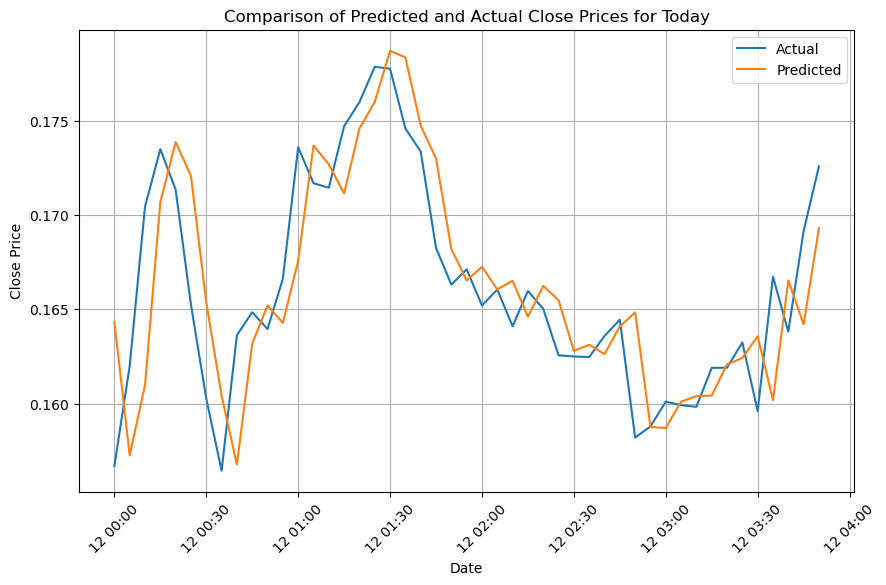

In [34]:
import datetime
# Get today's date
today = datetime.date.today()

# Filter the data for today
df_actual_today = df_actual[df_actual.index.date == today]
df_pred_today = df_pred[df_pred.index.date == today]

# Plot the actual and predicted values for today
plt.figure(figsize=(10, 6))
plt.plot(df_actual_today['Close'], label='Actual')
plt.plot(df_pred_today['Close'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Predicted and Actual Close Prices for Today')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Backtesting Strategy Using Moving Averages

In this section, we'll implement a backtesting strategy using simple moving averages (SMAs). We'll define a custom strategy class `MyStrategy` that uses SMAs to generate buy and sell signals. We'll then backtest this strategy using historical data and visualize the results.

#### Steps:
1. **Define the Custom Strategy Class**
2. **Backtest the Strategy**
3. **Plot the Backtest Results**

In [35]:

class MyStrategy(Strategy):

    stop_loss = 6  
    n1 = 10
    n2 = 100
    def init(self):
        # Define the indicators you want to use
        # Simple Moving Averages (SMAs)
        self.ma1 = self.I(SMA, self.data.Close, self.n1)
        self.ma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        # If the fast MA crosses above the slow MA, buy the asset
        if crossover(self.ma1, self.ma2):
            self.position.close()  # Close any existing position
            self.buy()
        # If the fast MA crosses below the slow MA, sell the asset and set a stop loss
        elif crossover(self.ma2, self.ma1):
            self.position.close()
            self.sell(sl=self.data.Close[-1] * (1 + self.stop_loss))  # stop loss

# Get your data
data = df_pred

# Initialize the backtest
bt = Backtest(data, MyStrategy, cash=10000,commission=.002,
              exclusive_orders=True)
bt.run()

bt.plot()
# Run the backtest
output = bt.run()


# # Print the output
print(output)

Start                     2024-05-31 18:55:00
End                       2024-06-12 03:50:00
Duration                     11 days 08:55:00
Exposure Time [%]                   94.274432
Equity Final [$]                 14362.088333
Equity Peak [$]                  48010.970628
Return [%]                          43.620883
Buy & Hold Return [%]              -31.396581
Return (Ann.) [%]               399579.747276
Volatility (Ann.) [%]     2164310073114.70...
Sharpe Ratio                              0.0
Sortino Ratio                     1434.250477
Calmar Ratio                      4631.178238
Max. Drawdown [%]                  -86.280365
Avg. Drawdown [%]                   -7.665306
Max. Drawdown Duration        2 days 10:30:00
Avg. Drawdown Duration        0 days 04:03:00
# Trades                                   32
Win Rate [%]                            31.25
Best Trade [%]                     146.847318
Worst Trade [%]                    -43.120812
Avg. Trade [%]                    